# The game plan

1. Load statefarm input as batches
1. Load VGG, observe the layers
1. Drop layers that do not seem necessary for my purposes
1. ~~Drop final convolution layers (what would be finding higher level features)~~
1. Save this as a new model
1. Evaluate and save the output from this piece-meal VGG. We will be using this pre-computed data to quickly train up a base model
1. Create a new model of ~~a few convolutional layers~~, fully connect connected layers w/ dropout and batch normalization, making sure it ends in our 10 categories via softmax
    1. ~~Why add convolutional layers? The last convolutional layers in VGG are for high level features for ImageNet, which we don't need. By adding our own, we hope high level features we need develop.~~--
    1. Why add batch normalization? It is not used earlier in VGG, but for our section of the model it will help fight overfittign.
    1. Why softmax - because it makes a nice even 0->1 score as an output, making it closer to the actual categorical output we desire (one-hot encoding is still likely required.
1. Start doing overfitting / underfitting fixes as we see fit

In [1]:
%matplotlib inline

In [2]:
import utils; reload(utils)
from utils import *

from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots, get_batches, plot_confusion_matrix, get_data

from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.
Using Theano backend.


# Preparing data
Please note that the notebook SF_Dir_Organization, which was originally taken from [here](https://gist.github.com/anonymous/ca79fd0cffaa122cbbf5933b5e1a4c69). 

As I've been working with it prior, I am assuming that the data has already been created.

In [3]:
path = "data/state/"

In [4]:
# batch_size - change depending on what you're doing
# batch_size = 4
batch_size = 64

In [5]:
from keras.preprocessing.image import ImageDataGenerator

#idg = ImageDataGenerator class

idg = ImageDataGenerator()

training_batch = idg.flow_from_directory(
    path + "/train",
    target_size=(224, 224), # Matching VGG's resolution
    class_mode='categorical',
    shuffle=False,
    batch_size=batch_size
)

valid_batch = idg.flow_from_directory(
    path + "/valid",
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    batch_size=batch_size
)

Found 18183 images belonging to 10 classes.
Found 4241 images belonging to 10 classes.


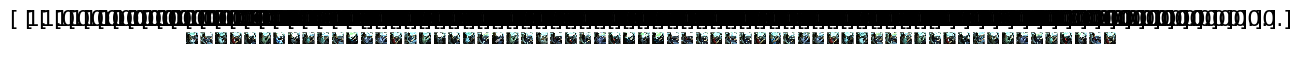

In [6]:
#Let's preview some images - only recommend this if batch_size is 4ish
imgs, labels = next(training_batch)
plots(imgs, titles=labels)

In [6]:
def onehot(x):
    return np.array(
        OneHotEncoder().fit_transform(x.reshape(-1,1)).todense()
    )

In [7]:
training_classes = training_batch.classes
valid_classes = valid_batch.classes
training_labels = onehot(training_batch.classes)
valid_labels = onehot(valid_batch.classes)

## What does the data look like?
The data comes in ten categories.
* c0: normal driving
* c1: texting - right
* c2: talking on the phone - right
* c3: texting - left
* c4: talking on the phone - left
* c5: operating the radio
* c6: drinking
* c7: reaching behind
* c8: hair and makeup
* c9: talking to passenger
Our goal is to get the image to one-hot encoded output for these ten categories

# Loading VGG and stripping it down

In [8]:
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [10]:
??Vgg16

In [9]:
vgg = Vgg16()

In [12]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [10]:
# Remove all layers up to the second to last CNN, so the last 11 layers
for i in range(0, 6):
    vgg.model.pop()

In [19]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

## Create model w/ the new layers

- Make a new model of the ending layers, consisting of fully connected blocks, consisting of:
    - A new flatten layer
    - A fully connected layer (2x) of 4096 neurons
    - dropout inbetween all dense layers
    - A final softmax dense layer
    
    
...which didn't work. No matter what I did I was stuck at 10% or below accuracy - no better than guessing.

After a lot of reading and searching, I decided to up the amount of FC layers by one with another ReLu activation and drastically lowering the learning rate. That started to show some promise.

In [11]:
model = Sequential()
model.add(Flatten(input_shape=(512,7,7)))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.))
model.add(Dense(10, activation='softmax'))

In [12]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
flatten_2 (Flatten)              (None, 25088)         0           flatten_input_1[0][0]            
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 4096)          102764544   flatten_2[0][0]                  
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 4096)          0           dense_4[0][0]                    
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 4096)          16781312    dropout_3[0][0]                  
___________________________________________________________________________________________

# Pre-calculate VGG outputs given our training and validation datasets

In [ ]:
vgg_output_training = vgg.model.predict_generator(
    training_batch,
    training_batch.nb_sample
)
vgg_output_valid = vgg.model.predict_generator(
    valid_batch,
    valid_batch.nb_sample
)

In [ ]:
# Save the data using fast.ai's save_array helper function
save_array(path + "vgg_output_training.bc", vgg_output_training)
save_array(path + "vgg_output_valid.bc", vgg_output_valid)

In [12]:
# Load the arrays up using the util function to save time
vgg_output_training = load_array(path + "vgg_output_training.bc")
vgg_output_valid = load_array(path + "vgg_output_valid.bc")

In [13]:
print(vgg_output_training.shape)
print(vgg_output_valid.shape)

(18183, 512, 7, 7)
(4241, 512, 7, 7)


# First attempt
For our first attempt we'll be just calling `fit_generator` on our new fully connected layer, without presetting the weights to anything special.

Note we're using the above pre-calculated outputs

In [13]:
model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

I set the learning rate here specifically because it took a lot of experimentation to find a decent learning rate. After getting nowhere with two FC ReLus, I upped it to a third and dropped the learning rate significantly to see if I could find any improvement towards a > 10% accuracy. I found .0000001 to work decently well to get out of the 10% hole.

In [14]:
model.optimizer.lr = .0000001

In [16]:
model.fit(
    vgg_output_training,
    training_labels,
    nb_epoch=10,
    batch_size=batch_size,
    validation_data=(vgg_output_valid, valid_labels)
)

Train on 18183 samples, validate on 4241 samples
Epoch 1/10
18183/18183 [==============================] - 374s - loss: 6.4022 - acc: 0.1385 - val_loss: 7.0520 - val_acc: 0.1273
Epoch 2/10
18183/18183 [==============================] - 365s - loss: 3.3892 - acc: 0.3019 - val_loss: 6.1169 - val_acc: 0.1620
Epoch 3/10
18183/18183 [==============================] - 362s - loss: 2.0927 - acc: 0.4859 - val_loss: 5.5144 - val_acc: 0.1981
Epoch 4/10
18183/18183 [==============================] - 363s - loss: 1.3554 - acc: 0.6350 - val_loss: 5.1051 - val_acc: 0.2235
Epoch 5/10
18183/18183 [==============================] - 365s - loss: 0.9300 - acc: 0.7357 - val_loss: 4.8199 - val_acc: 0.2457
Epoch 6/10
18183/18183 [==============================] - 364s - loss: 0.6726 - acc: 0.8055 - val_loss: 4.6274 - val_acc: 0.2669
Epoch 7/10
18183/18183 [==============================] - 369s - loss: 0.5077 - acc: 0.8557 - val_loss: 4.4721 - val_acc: 0.2837
Epoch 8/10
18183/18183 [========================

In [21]:
# Save these weights
model.save_weights(path + "no_dropout_training.hdf5")

In [15]:
# load the weights if you're just coming back
model.load_weights(path + "no_dropout_training.hdf5")

Overfitting for sure, which is good considering the sub 10% accuracy hole I was just in! I added in the dropout prior so I could fight overfitting later (not sure ATM how to add in dropout to a model post-initial fitting, should look into that). So for the next step, let's add dropout back in and see if that improves things.

In [16]:
# According to model.summary(), our dropout layers are 2, 4, and 6
model.layers[2].p = 0.5
model.layers[4].p = 0.5
model.layers[6].p = 0.5

In [17]:
model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
model.fit(
    vgg_output_training,
    training_labels,
    nb_epoch=10,
    batch_size=batch_size,
    validation_data=(vgg_output_valid, valid_labels)
)

Train on 18183 samples, validate on 4241 samples
Epoch 1/10
18183/18183 [==============================] - 403s - loss: 0.1983 - acc: 0.9453 - val_loss: 4.0116 - val_acc: 0.3299
Epoch 2/10
18183/18183 [==============================] - 396s - loss: 0.1448 - acc: 0.9611 - val_loss: 3.9567 - val_acc: 0.3386
Epoch 3/10
18183/18183 [==============================] - 397s - loss: 0.1096 - acc: 0.9715 - val_loss: 3.8779 - val_acc: 0.3490
Epoch 4/10
18183/18183 [==============================] - 402s - loss: 0.0845 - acc: 0.9804 - val_loss: 3.8257 - val_acc: 0.3542
Epoch 5/10
 8768/18183 [=============>................] - ETA: 198s - loss: 0.0701 - acc: 0.9841

KeyboardInterrupt: 

In [21]:
# Save these weights
model.save_weights(path + "with_dropout.hdf5")

In [18]:
# Load these weights
model.load_weights(path + "with_dropout.hdf5")

So after ten runs with dropout, we increased our overfitting, and only slightly increased validation accuracy - so we are still overfitting. But since we're no longer in that underfitting hole, we have room to breathe to improve.

# Data Augmentation

Let's try to use data augmentation in order to prevent over-fitting. I want to try this prior to Batch Normalization because VGG normalizes the input by subtracting its mean when pre-processing.

The problem with data augmentation is we can't precompute the first few layers now, so we have to rebuild the model, freeze the earlier convolutional layers, and start training.

Should we freeze the last few convolutional layers? Keeping the earlier layers makes sense, as that's where edge detectors and the like would be generated. Later layers, with mroe generalized features, might not fit our data set. For now, I'm going to build the model and not allow training on all convolutional layers, but post this I will open up the last few CNN layers in the model to try and retrain those layers.

In [19]:
full_model = Sequential()

for layer in vgg.model.layers:
    layer.trainable = False
    full_model.add(layer)
    
for layer in model.layers:
    full_model.add(layer)

In [20]:
full_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
                                                                   lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[0][0]            
                                                                   zeropadding2d_1[1][0]            
___________________________________________________________________________________________

In [27]:
from keras.preprocessing.image import ImageDataGenerator

#idg = ImageDataGenerator class

idg = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

training_batch = idg.flow_from_directory(
    path + "/train",
    target_size=(224, 224), # Matching VGG's resolution
    class_mode='categorical',
    shuffle=False,
    batch_size=batch_size
)

#reload idg simply because we don't want to
#modify the validation

idg = ImageDataGenerator()

valid_batch = idg.flow_from_directory(
    path + "/valid",
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
    batch_size=batch_size
)

Found 18183 images belonging to 10 classes.
Found 4241 images belonging to 10 classes.


In [22]:
full_model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
full_model.optimizer.lr = 0.0000001

In [48]:
full_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[1][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[1][0]            
___________________________________________________________________________________________

In [32]:
??keras.backend.function
#iterate = keras.backend.function([input_img, keras.backend.learning_phase()], [loss, grads])
#https://github.com/fchollet/keras/issues/2417

In [24]:
full_model.fit_generator(
    training_batch,
    samples_per_epoch=training_batch.nb_sample,
    nb_epoch=10,
    validation_data=valid_batch,
    nb_val_samples=valid_batch.nb_sample
)

MissingInputError: ("An input of the graph, used to compute DimShuffle{x,x}(keras_learning_phase), was not provided and not given a value.Use the Theano flag exception_verbosity='high',for more information on this error.", keras_learning_phase)